In [1]:
!pip install unsloth
!pip install tf-keras==2.16.0 --no-dependencies
!pip install "Pillow>=10.0.0"
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 KB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 KB 6.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 KB 6.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 29.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 KB 40.

In [26]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Quadro RTX 6000. Num GPUs = 1. Max memory: 23.461 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [27]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [3]:
import json
import pandas as pd
from datasets import Dataset
import os
from glob import glob

# Function to convert QA pairs to Alpaca format
def convert_to_alpaca_format(qa_pairs):
    alpaca_data = []
    
    for pair in qa_pairs:
        # Create Alpaca format entry
        entry = {
            "instruction": pair["question"],
            "output": pair["answer"]
        }
        alpaca_data.append(entry)
    
    return alpaca_data

# Load the JSON file
def load_qa_pairs(file_path):
    with open(file_path, 'r') as f:
        qa_pairs = json.load(f)
    return qa_pairs

# Main processing
def create_alpaca_dataset(directory_path):
    all_alpaca_data = []
    
    # Find all qa_pairs.json files in the directory and subdirectories
    json_files = glob(os.path.join(directory_path, "**/*qa_pairs.json"), recursive=True)
    
    print(f"Found {len(json_files)} QA pair files")
    
    # Process each file
    for json_file in json_files:
        qa_pairs = load_qa_pairs(json_file)
        alpaca_data = convert_to_alpaca_format(qa_pairs)
        all_alpaca_data.extend(alpaca_data)
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(all_alpaca_data)
    
    # Convert to HuggingFace Dataset
    dataset = Dataset.from_pandas(df)
    
    return dataset

# Example usage
# directory_path = "/home/ubuntu/PF_GM_aid/data/QA Pairs"  # Adjust this to your QA pairs directory
directory_path = '/Users/nicholasbarsi-rhyne/Documents/School/Graduate/Summer 25/GenAI/PF_GM_aid/data/QA Pairs'
dataset = create_alpaca_dataset(directory_path)

# Print some statistics
print("\nDataset statistics:")
print(f"Total number of examples: {len(dataset)}")
print("\nSample entry:")
print(dataset[0])

# Save the dataset if needed
# dataset.save_to_disk("path/to/save/dataset")

Found 79 QA pair files

Dataset statistics:
Total number of examples: 717

Sample entry:
{'instruction': "What does Rolth do as the town's member of law enforcement?", 'output': 'Rolth Garley settles disputes over livestock and breaks up the occasional drunken brawl.'}


In [29]:
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset[0]

{'instruction': 'Who are Magdelena and Martum Fallows?',
 'output': 'They are halfling twins who serve as the current "Farmer," the leader of the Bellflower Network, an abolitionist organization working to free halfling slaves in Cheliax.'}

In [4]:
chat_template = """<|im_start|>system
{SYSTEM}<|im_end|>
<|im_start|>user
{INPUT}<|im_end|>
<|im_start|>assistant
{OUTPUT}<|im_end|>"""

In [5]:
def format_chat_template(examples):
    chat_template = """<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
{INPUT}<|im_end|>
<|im_start|>assistant
{OUTPUT}<|im_end|>"""
    
    texts = []
    for i in range(len(examples["instruction"])):
        text = chat_template.format(
            INPUT=examples["instruction"][i],
            OUTPUT=examples["output"][i]
        )
        texts.append(text)
    
    return {"text": texts}

dataset = dataset.map(format_chat_template, batched=True)

Map:   0%|          | 0/717 [00:00<?, ? examples/s]

In [8]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
val_dataset = dataset_split['test']

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    add_special_tokens=True,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 20,
        num_train_epochs = 1,
        learning_rate = 5e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/717 [00:00<?, ? examples/s]

In [33]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 717 | Num Epochs = 4 | Total steps = 360
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Step,Training Loss
1,3.232800
2,3.434500
3,3.150200
4,3.154400
5,3.108600
6,2.783100
7,2.888800
8,2.730600
9,2.420900
10,2.213100


In [34]:
train_history = trainer.state.log_history
print("Training logs:", train_history)

# Extract specific metrics
losses = [log['train_loss'] for log in train_history if 'train_loss' in log]
learning_rates = [log['learning_rate'] for log in train_history if 'learning_rate' in log]

print(f"Final loss: {losses[-1] if losses else 'N/A'}")
print(f"Training steps: {trainer.state.global_step}")

Training logs: [{'loss': 3.2328, 'grad_norm': 1.8696959018707275, 'learning_rate': 0.0, 'epoch': 0.011142061281337047, 'step': 1}, {'loss': 3.4345, 'grad_norm': 1.965870976448059, 'learning_rate': 2e-05, 'epoch': 0.022284122562674095, 'step': 2}, {'loss': 3.1502, 'grad_norm': 1.6770148277282715, 'learning_rate': 4e-05, 'epoch': 0.033426183844011144, 'step': 3}, {'loss': 3.1544, 'grad_norm': 1.4508470296859741, 'learning_rate': 6e-05, 'epoch': 0.04456824512534819, 'step': 4}, {'loss': 3.1086, 'grad_norm': 1.147133708000183, 'learning_rate': 8e-05, 'epoch': 0.055710306406685235, 'step': 5}, {'loss': 2.7831, 'grad_norm': 1.0745567083358765, 'learning_rate': 0.0001, 'epoch': 0.06685236768802229, 'step': 6}, {'loss': 2.8888, 'grad_norm': 1.0245816707611084, 'learning_rate': 0.00012, 'epoch': 0.07799442896935933, 'step': 7}, {'loss': 2.7306, 'grad_norm': 1.0352387428283691, 'learning_rate': 0.00014, 'epoch': 0.08913649025069638, 'step': 8}, {'loss': 2.4209, 'grad_norm': 1.038892149925232, 'l

Final loss: 0.6485
Training steps: 360


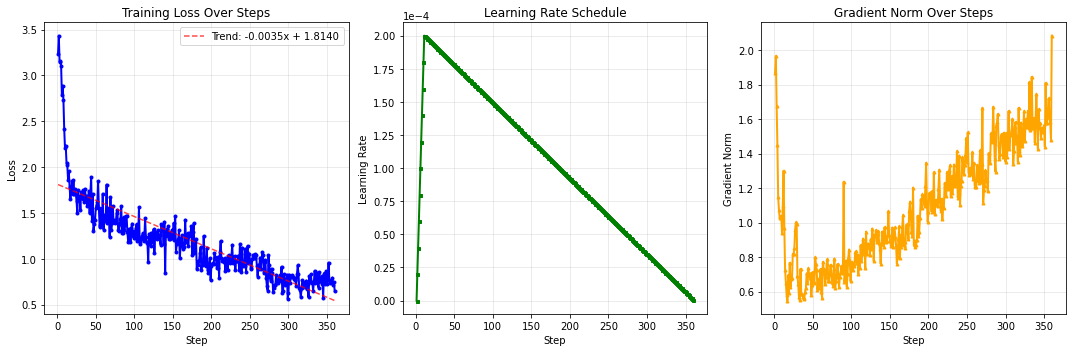


📊 Training Summary:
Initial loss: 3.2328
Final loss: 0.6485
Loss reduction: 2.5843
Percent improvement: 79.94%
Min loss: 0.5638 at step 299
Max gradient norm: 2.0841
Final gradient norm: 2.0841


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from training history
losses = [log['loss'] for log in train_history if 'loss' in log and 'train_runtime' not in log]
learning_rates = [log['learning_rate'] for log in train_history if 'learning_rate' in log and 'train_runtime' not in log]
grad_norms = [log['grad_norm'] for log in train_history if 'grad_norm' in log and 'train_runtime' not in log]
steps = [log['step'] for log in train_history if 'step' in log and 'train_runtime' not in log]

print(f"Final loss: {losses[-1] if losses else 'N/A'}")
print(f"Training steps: {steps[-1] if steps else 'N/A'}")

# Create plots
plt.figure(figsize=(15, 5))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.plot(steps, losses, 'b-', linewidth=2, marker='o', markersize=3)
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Add trend line
if len(losses) > 1:
   z = np.polyfit(steps, losses, 1)
   p = np.poly1d(z)
   plt.plot(steps, p(steps), 'r--', alpha=0.7, label=f'Trend: {z[0]:.4f}x + {z[1]:.4f}')
   plt.legend()

# Plot 2: Learning Rate Schedule
plt.subplot(1, 3, 2)
plt.plot(steps, learning_rates, 'g-', linewidth=2, marker='s', markersize=3)
plt.title('Learning Rate Schedule')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot 3: Gradient Norm
plt.subplot(1, 3, 3)
plt.plot(steps, grad_norms, 'orange', linewidth=2, marker='^', markersize=3)
plt.title('Gradient Norm Over Steps')
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary stats
print(f"\n📊 Training Summary:")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss reduction: {losses[0] - losses[-1]:.4f}")
print(f"Percent improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")
print(f"Min loss: {min(losses):.4f} at step {steps[losses.index(min(losses))]}")
print(f"Max gradient norm: {max(grad_norms):.4f}")
print(f"Final gradient norm: {grad_norms[-1]:.4f}")

In [36]:
# Enable inference mode
FastLanguageModel.for_inference(model)

# Format your input using the same chat template
def format_input(instruction):
    return f"""<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
{instruction}<|im_end|>
<|im_start|>assistant
"""

# Run inference
instruction = "Who is Eutropia?"
inputs = tokenizer(format_input(instruction), return_tensors="pt").to("cuda")

outputs = model.generate(
    **inputs,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Who is Eutropia?<|im_end|>
<|im_start|>assistant
Eutropia is the ruler of Eurythnia, a human nation located in the River Kingdoms, known for her love of books, scholarship, and her title as the "Wise One".<|im_end|>


## Save the model

In [21]:
# Save LoRA adapter
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

# Save merged model  
model.save_pretrained_merged("merged_model", tokenizer, save_method="merged_16bit")

print("✅ Models saved!")
print("LoRA adapter: ./lora_model/")
print("Merged model: ./merged_model/")

Found HuggingFace hub cache directory: /home/ubuntu/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:51<00:00, 25.60s/it]


✅ Models saved!
LoRA adapter: ./lora_model/
Merged model: ./merged_model/


# Load the model

In [22]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="lora_model",  # Your saved model path
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Quadro RTX 6000. Num GPUs = 1. Max memory: 23.461 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Save for ollama

In [37]:
model.save_pretrained_gguf("ollama_model", tokenizer, quantization_method="q4_k_m")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 26.17 out of 45.08 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 60.70it/s]


Unsloth: Saving tokenizer... Done.
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at ollama_model into f16 GGUF format.
The output location will be /home/ubuntu/PF_GM_aid/fine-tune/ollama_model/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ollama_model
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 